In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp

np.set_printoptions(linewidth=140, edgeitems=10, precision=2, suppress=True)

In [2]:
#---Mechanism Constants---
NB = np.arange(3) #Number of bodies for sanity check
L = np.array([10, 26, 18]) #[m]
M = np.array([3, 5, 4]) #[kg]
J = 1/12 * M * L**2 #Assume thin rod m/12 * l² [kg * m²]
G = 20 #Ground distance
g = 9.81 #Gravitational force

#---Joint Definitions---
i_bodies = np.array([0, 0, 1, 2])
j_bodies = np.array([-1, 1, 2, -1])

i_points = np.array([[-L[0]/2, 0], [L[0]/2, 0],
                     [L[1]/2, 0], [L[2]/2, 0]])

j_points = np.array([[np.nan, np.nan], [-L[1]/2, 0],
                     [-L[2]/2, 0], [np.nan, np.nan]])

#---ground points for the two ground joints---
ground_points = np.zeros((len(i_bodies), 2))
ground_points[0] = np.array([0.0, 0.0])   # left ground pin
ground_points[3] = np.array([G,   0.0])   # right ground pin

#---Force Constants---
K_rot = np.array([0, 0, 1000000]) #[Nm/rad]
C_rot = np.array([0, 0, 10000]) #[Nm*s/rad]

#Equilibrium condition for spring in local frame
#(for connection to ground this will only depend on the body)
static_angles_rot = np.array([0, 0, np.deg2rad(270)])
connection_rot = np.array([-1, -1, -1])

#---Initial Conditions---
# --- choose which body to “drive” and the target angle (in radians) ---
body_idx_to_drive = 0
theta_target = np.deg2rad(70.0)


#If no guess then zeros
q0 = np.zeros(9)
#body 0 IC at 90 deg
q0[0:3] = [0.0, L[0]/2, np.pi/2]                 # body 0
#body 1 somewhere in between, with a reasonable angle guess
q0[3:6] = [ G/2,  L[0]/2,  np.deg2rad(10.0) ]    # body 1
#body 2 at 270 deg
q0[6:9] = [ G, L[2]/2, np.pi*1.5]                # body 2


#---Helper Functions---
def get_indices(b, *, q=None):
    """
    This function gets the indices from the slices of the generalized coordinates.
    If q is provided then it will be split up into [x,y] and phi.
    Accepts a single int or an array-like of ints for `b`.
    """

    b_arr = np.atleast_1d(b).astype(int)

    if q is None:
        if b_arr.size == 1:
            i = b_arr[0]
            return slice(3*i, 3*i+3)
        return [slice(3*i, 3*i+3) for i in b_arr]

    q = np.asarray(q)
    if q.size % 3 != 0:
        raise ValueError("q length must be a multiple of 3")

    if b_arr.size == 1:
        i = b_arr[0]
        x, y, phi = q[3*i:3*i+3]
        return np.array([x, y]), phi

    xy  = np.vstack([q[3*i:3*i+2] for i in b_arr])
    phi = np.array([q[3*i+2] for i in b_arr])
    return xy, phi


#---Rotation Functions---
def A(phi):
    return np.array([[np.cos(phi), -np.sin(phi)],
                     [np.sin(phi),  np.cos(phi)]])

def B(phi):  # dA/dphi
    return np.array([[-np.sin(phi), -np.cos(phi)],
                     [ np.cos(phi), -np.sin(phi)]])


#---Mass Matrix---
def get_mass_matrix(bodies, masses, inertias):
    """
    This function assembles the mass matrix from body array, masses and inertias.
    """
    body_indices = np.arange(len(bodies))
    mass_block = lambda body_idx: np.array([masses[body_idx], masses[body_idx], inertias[body_idx]])
    
    for submatrix, _ in enumerate(body_indices):
        if submatrix == 0:
            mass_inertia_elements = mass_block(submatrix)
        else:
            mass_inertia_elements = np.hstack((mass_inertia_elements, mass_block(submatrix)))
    
    mass_matrix = np.diag(mass_inertia_elements)

    return mass_matrix


def get_generalized_forces(q, q_dot, bodies, mass_vector, *,
                           gravity=9.81,
                           rot_spring=None,
                           neutral_angle=None,
                           rot_damper=None,
                           connection_rot=None):
    """
    Compute generalized forces = gravity + (optional) rotational spring-damper torques.

    """

    # --- gravity ---
    gravitational_forces = np.zeros_like(q)

    for body_idx in bodies:
        gravitational_forces[body_idx*3 + 1] += -gravity * mass_vector[body_idx]

    # --- spring-damper (optional) ---
    spring_damper_forces = np.zeros_like(q)
    if (rot_spring is not None
        and neutral_angle is not None
        and rot_damper is not None
        and connection_rot is not None):

        # helper to allow scalar or per-body arrays for damping, etc.
        def at(x, i):
            return x if np.isscalar(x) else x[i]

        for i, connection in enumerate(connection_rot):
            if connection == -1:  # ground
                # read angles
                _, phi     = get_indices(i, q=q)
                _, phi_dot = get_indices(i, q=q_dot)

                k   = at(rot_spring, i)
                c   = at(rot_damper, i)
                phi0= at(neutral_angle, i)

                # wrapped error to avoid discontinuities
                err = phi - phi0
                torque = -k * err - c * phi_dot

                spring_damper_forces[i*3 + 2] += torque
            else:
                raise NotImplementedError(
                    f"Relative rotational connection (body {i} to {connection}) not supported yet."
                )

    # --- sum ---
    return gravitational_forces + spring_damper_forces



#---Constraint functions---
def get_revolute_constraints(q, q_dot, body_i, s_i, body_j=None, s_j=None, ground_point=None):
    """
    Returns (phi, jacobian, gamma) for a 2D revolute joint.
    - body-ground: body_j=None, s_j ignored, ground_point is a 2D world point.
    - body-body:   body_j is an int, s_j is a 2D local point on body_j.

    Shapes:
      body-ground -> phi:(2,), J:(2x3) over [x_i, y_i, phi_i],    gamma:(2,)
      body-body   -> phi:(2,), J:(2x6) over [x_i, y_i, phi_i, x_j, y_j, phi_j], gamma:(2,)
    """

    # --- read body i state ---
    r_i, phi_i = get_indices(body_i, q=q)       # r_i: (2,), phi_i: scalar
    _,   w_i   = get_indices(body_i, q=q_dot)   # w_i = phi_dot_i (scalar)

    if body_j is None:
        # ---------- Revolute to ground at 'ground_point' ----------
        if ground_point is None:
            raise ValueError("For a ground revolute, provide ground_point (2,).")

        Ai = A(phi_i)         # 2x2
        Bi = B(phi_i)         # 2x2
        s_i = np.asarray(s_i).reshape(2)

        # Position-level constraints: r_i + A_i s_i - C = 0
        phi = r_i + Ai @ s_i - np.asarray(ground_point).reshape(2)

        # Jacobian wrt [x_i, y_i, phi_i]
        # d(r_i)/dq_i -> I2; d(A_i s_i)/dphi_i -> B_i s_i
        J_i = np.column_stack((np.eye(2), Bi @ s_i))  # 2x3
        jacobian = J_i

        # Gamma (acceleration RHS): A_i s_i * (phi_dot_i)^2
        gamma = Ai @ s_i * (w_i**2)

        return phi, jacobian, gamma

    else:
        # ---------- Revolute between body i and body j ----------
        r_j, phi_j = get_indices(body_j, q=q)
        _,   w_j   = get_indices(body_j, q=q_dot)

        Ai = A(phi_i);  Bi = B(phi_i)
        Aj = A(phi_j);  Bj = B(phi_j)

        s_i = np.asarray(s_i).reshape(2)
        s_j = np.asarray(s_j).reshape(2)

        # Position-level: r_j + A_j s_j - r_i - A_i s_i = 0
        phi = (r_j + Aj @ s_j) - (r_i + Ai @ s_i)

        # Jacobian wrt [x_i, y_i, phi_i,  x_j, y_j, phi_j]
        # i-block = [-I2, -B_i s_i],  j-block = [I2, B_j s_j]
        J_i = np.column_stack((-np.eye(2), -(Bi @ s_i)))   # 2x3
        J_j = np.column_stack(( np.eye(2),  (Bj @ s_j)))   # 2x3
        jacobian = np.hstack((J_i, J_j))                   # 2x6

        # Gamma:  A_j s_j * w_j^2 - A_i s_i * w_i^2
        gamma = (Aj @ s_j) * (w_j**2) - (Ai @ s_i) * (w_i**2)

        return phi, jacobian, gamma

def assemble_constraints(q, q_dot, i_bodies, j_bodies, i_points, j_points, ground_points=None):
    """
    Assemble system-level (Phi, Jacobian, Gamma) for all revolute joints.

    i_bodies, j_bodies: arrays of ints; use -1 in j_bodies for ground.
    i_points, j_points: arrays of shape (m,2) with local [x,y] points.
    ground_points: optional (m,2) world points for ground joints; default [0,0] per joint.
    """
    m = len(i_bodies)
    n = q.size
    Phi     = np.zeros(2*m) #(8,) here
    Gamma   = np.zeros(2*m) #(8,) here
    J_sys   = np.zeros((2*m, n)) #(8,9) here

    if ground_points is None:
        ground_points = np.zeros((m, 2))

    for k in range(m):
        bi = int(i_bodies[k])
        bj = int(j_bodies[k])
        s_i = np.asarray(i_points[k]).reshape(2)

        row = slice(2*k, 2*k+2)

        if bj == -1:
            gp = np.asarray(ground_points[k]).reshape(2)
            phi, Jloc, gam = get_revolute_constraints(q, q_dot, body_i=bi, s_i=s_i, ground_point=gp)
            Phi[row]   = phi
            Gamma[row] = gam
            J_sys[row, 3*bi:3*bi+3] = Jloc
        else:
            s_j = np.asarray(j_points[k]).reshape(2)
            phi, Jloc, gam = get_revolute_constraints(q, q_dot, body_i=bi, s_i=s_i, body_j=bj, s_j=s_j)
            Phi[row]   = phi
            Gamma[row] = gam
            # split the 2x6 local Jacobian into i and j blocks
            J_sys[row, 3*bi:3*bi+3] = Jloc[:, 0:3]
            J_sys[row, 3*bj:3*bj+3] = Jloc[:, 3:6]

    return Phi, J_sys, Gamma


#---Initial Condition solving ---
def make_system_with_driver(body_idx, theta_target, ground_points=None):
    """
    Returns (phi_fn, jac_fn) that append one scalar driver:
        q[3*body_idx+2] - theta_target = 0
    """
    if ground_points is None:
        ground_points = np.zeros((len(i_bodies), 2))
        ground_points[0] = np.array([0.0, 0.0])
        ground_points[3] = np.array([G, 0.0])

    def phi_fn(q_col, t=0):
        q = np.asarray(q_col).ravel()
        q_dot = np.zeros_like(q)
        Phi, _, _ = assemble_constraints(q, q_dot, i_bodies, j_bodies, i_points, j_points, ground_points)
        theta = q[3*body_idx + 2]
        Phi_drv = np.array([theta - theta_target])   # 1x
        return np.concatenate([Phi, Phi_drv]).reshape(-1, 1)

    def jac_fn(q_col):
        q = np.asarray(q_col).ravel()
        q_dot = np.zeros_like(q)
        _, J, _ = assemble_constraints(q, q_dot, i_bodies, j_bodies, i_points, j_points, ground_points)
        J_drv = np.zeros((1, J.shape[1]))
        J_drv[0, 3*body_idx + 2] = 1.0               # Inserted driver
        return np.vstack([J, J_drv])

    return phi_fn, jac_fn

# Newton Rhapson performed as "vectorfunction" as to call the system of equations instead of element-wise
def newton_rhapson(function,
                   initial_guess,
                   jacobian,
                   t=0, rtol=1e-3, max_iter=500, verbose=False):
    # counters and initial guess
    old_val = np.asarray(initial_guess).reshape(-1, 1)
    norm = np.inf

    for it in range(max_iter):
        if norm <= rtol:
            break

        # evaluate
        F = function(old_val, t)                 # (m,1)
        J = jacobian(old_val)                    # (m,n)

        # step: q_{k+1} = q_k - J^+ F   (pseudo-inverse for non-square J)
        J_pinv = np.linalg.inv(J)
        current_val = old_val - J_pinv @ F

        norm = np.linalg.norm(current_val - old_val)
        old_val = current_val

    if verbose:
        print(f"The Newton Rhapson finished in {it+1} iterations with a tolerance of {norm:.3e}")
    return old_val



In [3]:
# --- build the augmented system with the angle driver on body_idx_to_drive ---
phi_fn, jac_fn = make_system_with_driver(body_idx_to_drive, theta_target, ground_points)

# --- solve for a consistent pose ---
q_init = newton_rhapson(phi_fn, q0, jac_fn, rtol=1e-10, max_iter=200, verbose=True).ravel()

# zero initial velocities, as required
v_init = np.zeros_like(q_init)

#print initial condition
print(q_init, v_init)

The Newton Rhapson finished in 7 iterations with a tolerance of 5.691e-15
[ 1.71  4.7   1.22 16.02 12.6   0.25 24.31  7.9   4.21] [0. 0. 0. 0. 0. 0. 0. 0. 0.]


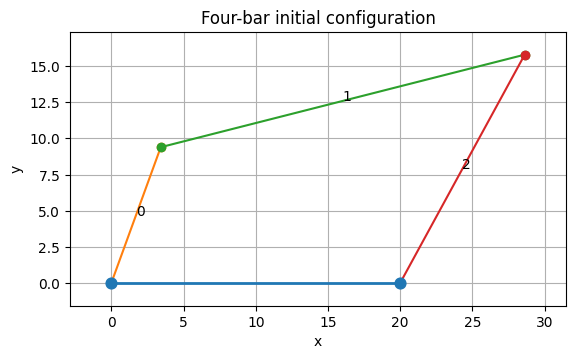

In [4]:
#Plotting function to see initial config of mechanism

def wrap_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

def endpoint(r, phi, s):
    c, sng = np.cos(phi), np.sin(phi)
    A = np.array([[c, -sng],[sng, c]])
    return r + A @ s

def plot_mechanism(q_col, L, G, title="Initial configuration"):
    q = np.asarray(q_col).ravel().copy()
    # wrap angles to (-pi, pi] to avoid full turns
    for b in (0,1,2):
        q[3*b + 2] = wrap_pi(q[3*b + 2])

    # local endpoints
    s0L, s0R = np.array([-L[0]/2, 0.0]), np.array([ L[0]/2, 0.0])
    s1L, s1R = np.array([-L[1]/2, 0.0]), np.array([ L[1]/2, 0.0])
    s2L, s2R = np.array([-L[2]/2, 0.0]), np.array([ L[2]/2, 0.0])

    r0, th0 = q[0:2], q[2]
    r1, th1 = q[3:5], q[5]
    r2, th2 = q[6:8], q[8]

    # world joints
    J0 = endpoint(r0, th0, s0L)    # ground @ (0,0)
    J1 = endpoint(r0, th0, s0R)
    J1b= endpoint(r1, th1, s1L)
    J2 = endpoint(r1, th1, s1R)
    J2b= endpoint(r2, th2, s2L)
    J3 = endpoint(r2, th2, s2R)    # ground @ (G,0)

    # plot (default styles; no explicit colors)
    plt.figure()
    plt.plot([0, G], [0, 0], linewidth=2)                # ground line
    plt.plot([J0[0], J1[0]], [J0[1], J1[1]], marker='o') # body 0
    plt.plot([J1[0], J2[0]], [J1[1], J2[1]], marker='o') # body 1
    plt.plot([J2[0], J3[0]], [J2[1], J3[1]], marker='o') # body 2
    plt.scatter([0, G], [0, 0], s=60, zorder=5)          # ground pins

    # labels
    cm0=(J0+J1)/2; cm1=(J1+J2)/2; cm2=(J2+J3)/2
    plt.text(cm0[0], cm0[1], "0"); plt.text(cm1[0], cm1[1], "1"); plt.text(cm2[0], cm2[1], "2")

    # neat axes
    all_x = np.array([0, G, J0[0], J1[0], J2[0], J3[0]])
    all_y = np.array([0, 0, J0[1], J1[1], J2[1], J3[1]])
    xpad = max(1.0, 0.1*(all_x.max()-all_x.min()+1e-9))
    ypad = max(1.0, 0.1*(all_y.max()-all_y.min()+1e-9))
    plt.xlim(all_x.min()-xpad, all_x.max()+xpad)
    plt.ylim(all_y.min()-ypad, all_y.max()+ypad)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title); plt.xlabel("x"); plt.ylabel("y"); plt.grid()
    plt.savefig(f"initial_config.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_mechanism(q_init, L, G, title="Four-bar initial configuration")


In [5]:
# small, single-place tuning knobs (set OMEGA=0.0 to disable stabilization)
alpha  = 10.0
beta = 200.0   

def forward_dynamics_rhs(t, y):
    """
    Standard IVP RHS: y' = f(t,y)
    y = [q ; qdot] -> returns [qdot ; qddot]
    Uses solving with optional Baumgarte stabilization to reduce drift.
    """
    n = y.size // 2 
    q, qdot = y[:n], y[n:] #divide state into pos and vel

    # mass & generalized forces
    Mmat = get_mass_matrix(NB, M, J)
    Q    = get_generalized_forces(q, qdot,
                                  bodies=NB, mass_vector=M,
                                  gravity=g,
                                  rot_spring=K_rot,
                                  neutral_angle=static_angles_rot,
                                  rot_damper=C_rot,
                                  connection_rot=connection_rot)

    # holonomic constraints (revolute)
    Phi, Phi_q, Gamma = assemble_constraints(q, qdot,
                                             i_bodies, j_bodies,
                                             i_points, j_points,
                                             ground_points)
    m = Phi_q.shape[0]

    # Baumgarte stabilization: Φ̈ + 2*alpha Φ̇ + Beta² Φ = 0
    Phi_dot = Phi_q @ qdot
    rhs_c   = -Gamma - 2*alpha*beta*Phi_dot - (beta**2)*Phi

    # solve: [M  Phi_q^T; Phi_q  0] [qddot; λ] = [Q; rhs_c]
    lhs = np.block([[Mmat,           Phi_q.T],
                    [Phi_q, np.zeros((m, m))]])
    rhs = np.concatenate([Q, rhs_c])
    sol = np.linalg.solve(lhs, rhs)

    qddot = sol[:n]
    return np.hstack([qdot, qddot])

t_span = (0.0, 15.0)
t_eval = np.linspace(*t_span, int(30*(t_span[1]-t_span[0])) + 1)
max_step_size = 0.001

# initial state (positions from q_init, zero velocities from v_init)
y0 = np.hstack((q_init, v_init))
sol = solve_ivp(forward_dynamics_rhs, t_span, y0,
                method="RK45", rtol=1e-7, atol=1e-9,
                t_eval=t_eval, max_step=max_step_size)


In [6]:
Phi, Phi_q, Gamma = assemble_constraints(q_init, v_init,
                                            i_bodies, j_bodies,
                                            i_points, j_points,
                                            ground_points)

print(Phi_q)

[[  1.     0.     4.7    0.     0.     0.     0.     0.     0.  ]
 [  0.     1.    -1.71   0.     0.     0.     0.     0.     0.  ]
 [ -1.    -0.     4.7    1.     0.     3.2    0.     0.     0.  ]
 [ -0.    -1.    -1.71   0.     1.   -12.6    0.     0.     0.  ]
 [  0.     0.     0.    -1.    -0.     3.2    1.     0.    -7.9 ]
 [  0.     0.     0.    -0.    -1.   -12.6    0.     1.     4.31]
 [  0.     0.     0.     0.     0.     0.     1.     0.     7.9 ]
 [  0.     0.     0.     0.     0.     0.     0.     1.    -4.31]]


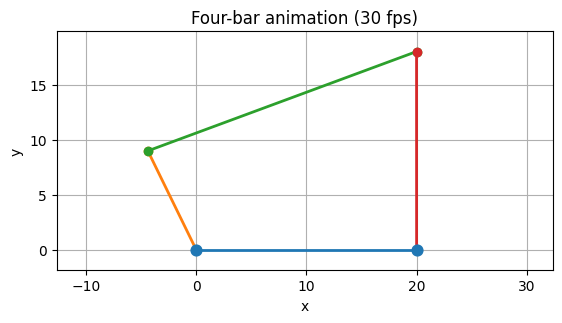

In [7]:
#Animation of the motion
# pull positions only from the solution
nq   = sol.y.shape[0] // 2
t    = sol.t
qall = sol.y[:nq, :]   # shape (9, K)

# choose 30 fps timestamps and pick nearest samples from `sol`
fps = 30
t_anim = np.linspace(t[0], t[-1], int((t[-1]-t[0])*fps)+1)
idx = np.searchsorted(t, t_anim)
idx[idx >= t.size] = t.size - 1
q_frames = qall[:, idx].T  # (Nframes, nq)

# local endpoints (left/right) for each body in its frame
s0L, s0R = np.array([-L[0]/2, 0.0]), np.array([ L[0]/2, 0.0])
s1L, s1R = np.array([-L[1]/2, 0.0]), np.array([ L[1]/2, 0.0])
s2L, s2R = np.array([-L[2]/2, 0.0]), np.array([ L[2]/2, 0.0])

def joints_from_q(q):
    """Return world joint points (J0..J3) for pose q."""
    r0, th0 = q[0:2], q[2]
    r1, th1 = q[3:5], q[5]
    r2, th2 = q[6:8], q[8]
    J0 = endpoint(r0, th0, s0L)     # ground @ (0,0)
    J1 = endpoint(r0, th0, s0R)
    J2 = endpoint(r1, th1, s1R)
    J3 = endpoint(r2, th2, s2R)     # ground @ (G,0)
    return J0, J1, J2, J3

# compute axis limits once from all frames
xs, ys = [0.0, G], [0.0, 0.0]
for q in q_frames:
    J0, J1, J2, J3 = joints_from_q(q)
    xs += [J0[0], J1[0], J2[0], J3[0]]
    ys += [J0[1], J1[1], J2[1], J3[1]]
xs, ys = np.array(xs), np.array(ys)
xpad = max(1.0, 0.1*(xs.max()-xs.min()+1e-9))
ypad = max(1.0, 0.1*(ys.max()-ys.min()+1e-9))
XLIMS = (xs.min()-xpad, xs.max()+xpad)
YLIMS = (ys.min()-ypad, ys.max()+ypad)

# set up the figure
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(*XLIMS); ax.set_ylim(*YLIMS)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Four-bar animation (30 fps)")
ax.grid()

# ground line & pins
ax.plot([0, G], [0, 0], linewidth=2)
ax.scatter([0, G], [0, 0], s=60, zorder=5)

# link segments (updated each frame)
(seg0,) = ax.plot([], [], marker='o', linewidth=2)  # body 0
(seg1,) = ax.plot([], [], marker='o', linewidth=2)  # body 1
(seg2,) = ax.plot([], [], marker='o', linewidth=2)  # body 2

def init():
    seg0.set_data([], []); seg1.set_data([], []); seg2.set_data([], [])
    return seg0, seg1, seg2

def animate(k):
    q = q_frames[k]
    J0, J1, J2, J3 = joints_from_q(q)
    seg0.set_data([J0[0], J1[0]], [J0[1], J1[1]])
    seg1.set_data([J1[0], J2[0]], [J1[1], J2[1]])
    seg2.set_data([J2[0], J3[0]], [J2[1], J3[1]])
    return seg0, seg1, seg2

anim = FuncAnimation(fig, animate, frames=len(q_frames),
                     init_func=init, interval=1000/fps, blit=True)

# Optional: save (requires ffmpeg)
anim.save("fourbar_30fps.mp4", writer="ffmpeg", fps=fps)
plt.show()


In [8]:
# === Save first/last animation frames as PNGs ===
k_first = 0
k_last  = len(q_frames) - 1

def save_frame(k, path):
    # Update artists to frame k and force a draw, then save.
    animate(k)                  # uses your animate() to set seg0/seg1/seg2
    fig.canvas.draw()           # ensure the canvas is rendered
    fig.savefig(path, dpi=300, bbox_inches="tight")

save_frame(k_first, "fourbar_frame_first.png")
save_frame(k_last,  "fourbar_frame_last.png")

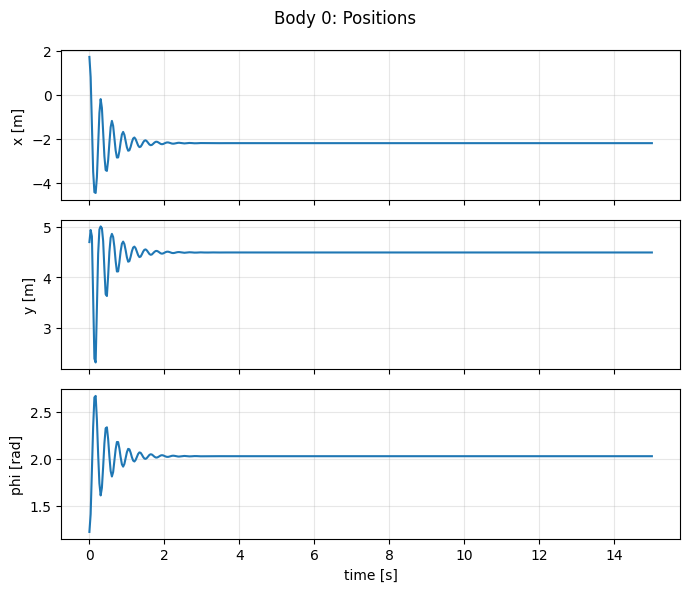

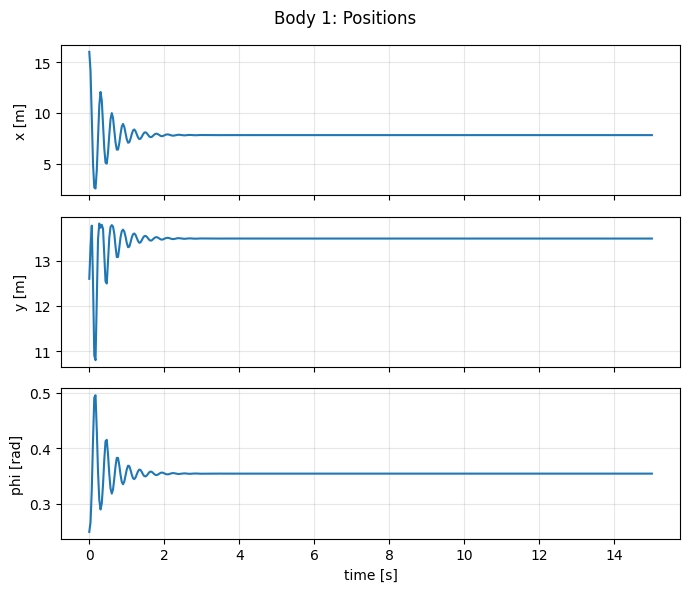

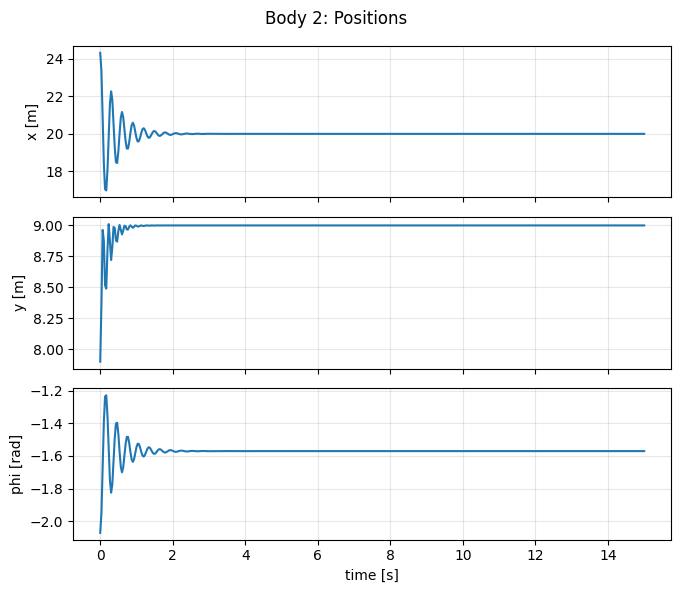

In [9]:
#---Position Plots---
# extract time and positions from the solution
t   = sol.t
nq  = sol.y.shape[0] // 2
q   = sol.y[:nq, :].T   # shape (K, 3*NB)

def plot_body_positions(b):
    i = 3*b
    x  = q[:, i + 0]
    y  = q[:, i + 1]
    ph = np.array([wrap_pi(a) for a in q[:, i + 2]])

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 6))
    ax[0].plot(t, x);  ax[0].set_ylabel("x [m]"); ax[0].grid(True, which="both", alpha=0.3)
    ax[1].plot(t, y);  ax[1].set_ylabel("y [m]"); ax[1].grid(True, which="both", alpha=0.3)
    ax[2].plot(t, ph); ax[2].set_ylabel("phi [rad]"); ax[2].grid(True, which="both", alpha=0.3)
    ax[2].set_xlabel("time [s]")
    fig.suptitle(f"Body {b}: Positions")
    plt.tight_layout()
    plt.savefig(f"pos_body_{b}.png", dpi=300, bbox_inches="tight")
    plt.show()

for b in range(len(NB)):
    plot_body_positions(b)


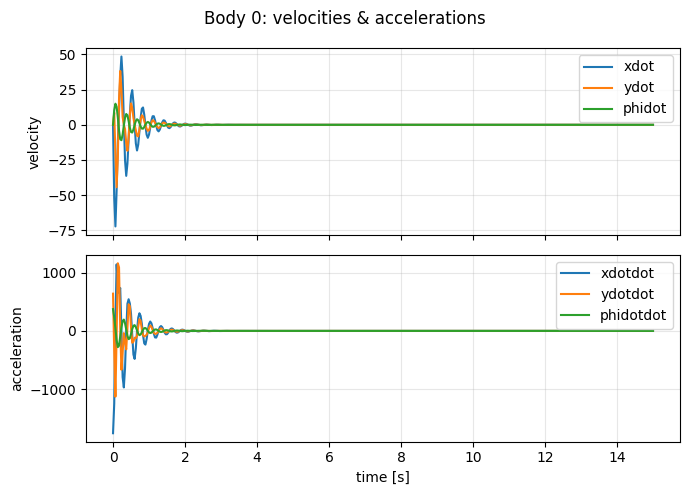

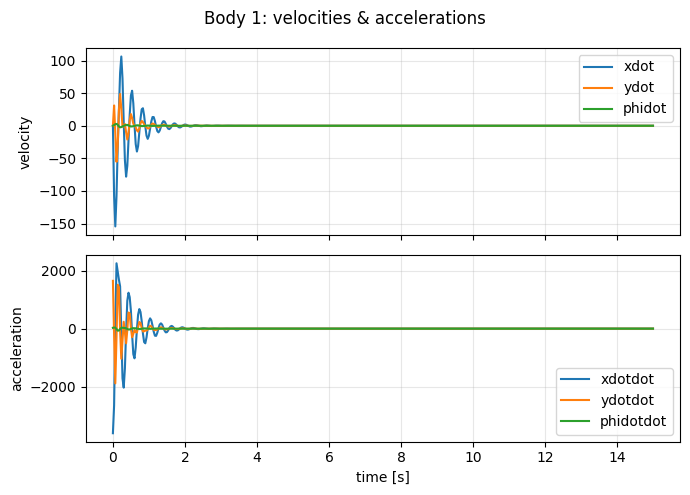

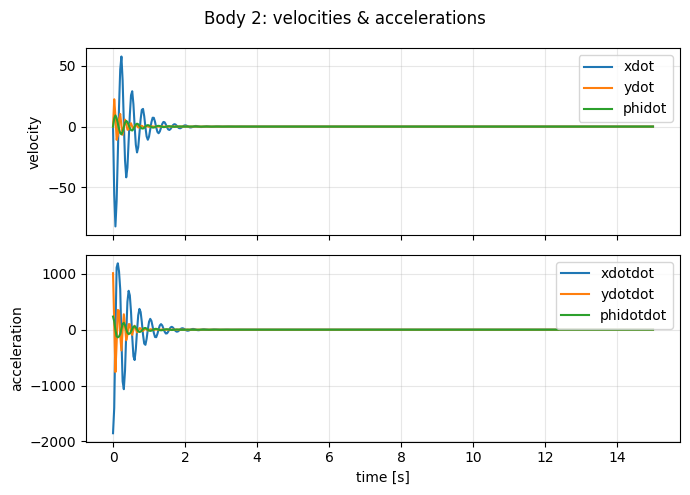

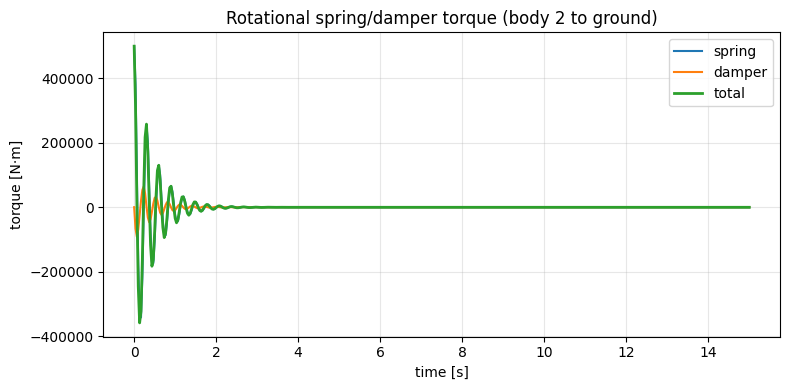

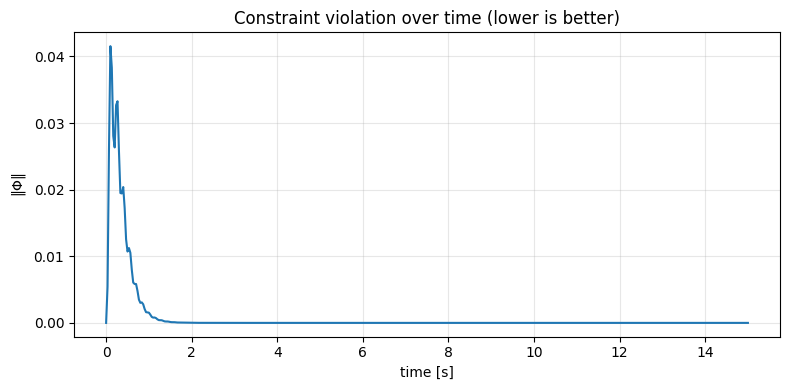

In [10]:
# ==== Post-processing: vel/acc plots, spring/damper torque, joint reactions, constraint check ====

# unpack solution
t    = sol.t
nq   = sol.y.shape[0] // 2
q    = sol.y[:nq, :].T      # (K, 3*NB)
qdot = sol.y[nq:, :].T      # (K, 3*NB)

# helper: recover accelerations and multipliers consistent with your stabilized RHS
def kkt_accel_and_lambda(qi, qdi):
    Mmat = get_mass_matrix(NB, M, J)
    Q    = get_generalized_forces(qi, qdi,
                                  bodies=NB, mass_vector=M,
                                  gravity=g,
                                  rot_spring=K_rot,
                                  neutral_angle=static_angles_rot,
                                  rot_damper=C_rot,
                                  connection_rot=connection_rot)
    Phi, Phi_q, Gamma = assemble_constraints(qi, qdi, i_bodies, j_bodies, i_points, j_points, ground_points)
    Phi_dot = Phi_q @ qdi
    rhs_c   = -Gamma - 2*alpha*beta*Phi_dot - (beta**2)*Phi
    m = Phi_q.shape[0]
    KKT = np.block([[Mmat,           Phi_q.T],
                    [Phi_q, np.zeros((m, m))]])
    rhs = np.concatenate([Q, rhs_c])
    solK = np.linalg.solve(KKT, rhs)
    return solK[:qi.size], solK[qi.size:]

# compute accelerations and multipliers along the trajectory
qddot = np.zeros_like(q)
lam_list = []
phi_norm = []
for qi, qdi in zip(q, qdot):
    qdd, lam = kkt_accel_and_lambda(qi, qdi)
    qddot[len(lam_list)] = qdd
    lam_list.append(lam)
    Phi, _, _ = assemble_constraints(qi, qdi, i_bodies, j_bodies, i_points, j_points, ground_points)
    phi_norm.append(np.linalg.norm(Phi))

lam = np.vstack(lam_list)      # (K, 2*m_joints)
phi_norm = np.array(phi_norm)  # (K,)

# ---------- velocities & accelerations per body ----------
def plot_body_kinematics(b):
    i = 3*b
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
    ax[0].plot(t, qdot[:, i+0], label="xdot")
    ax[0].plot(t, qdot[:, i+1], label="ydot")
    ax[0].plot(t, qdot[:, i+2], label="phidot")
    ax[0].set_ylabel("velocity"); ax[0].legend()
    ax[0].grid(True, which="both", alpha=0.3)

    ax[1].plot(t, qddot[:, i+0], label="xdotdot")
    ax[1].plot(t, qddot[:, i+1], label="ydotdot")
    ax[1].plot(t, qddot[:, i+2], label="phidotdot")
    ax[1].set_ylabel("acceleration"); ax[1].set_xlabel("time [s]"); ax[1].legend()
    ax[1].grid(True, which="both", alpha=0.3)
    fig.suptitle(f"Body {b}: velocities & accelerations")
    plt.savefig(f"vel_acc_body_{b}.png", dpi=300, bbox_inches="tight")
    plt.tight_layout(); plt.show()

for b in range(len(NB)):
    plot_body_kinematics(b)

# ---------- spring & damper torque on body 2 (only body with nonzero K,C in your setup) ----------
b = 2
phi   = q[:,    3*b + 2]
phdot = qdot[:, 3*b + 2]
tau_spring = -K_rot[b] * (phi - static_angles_rot[b])
tau_damper = -C_rot[b] * phdot
tau_total  = tau_spring + tau_damper

plt.figure(figsize=(8,4))
plt.plot(t, tau_spring, label="spring")
plt.plot(t, tau_damper, label="damper")
plt.plot(t, tau_total,  label="total", linewidth=2)
plt.xlabel("time [s]"); plt.ylabel("torque [N·m]")
plt.title("Rotational spring/damper torque (body 2 to ground)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(f"spring_damper_body_{b}.png", dpi=300, bbox_inches="tight")
plt.show()


# ---------- constraint violation (sanity check) ----------
plt.figure(figsize=(8,4))
plt.plot(t, phi_norm)
plt.xlabel("time [s]"); plt.ylabel(r"$\|\Phi\|$")
plt.title("Constraint violation over time (lower is better)")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(f"constraint_body_{b}.png", dpi=300, bbox_inches="tight")
plt.show()



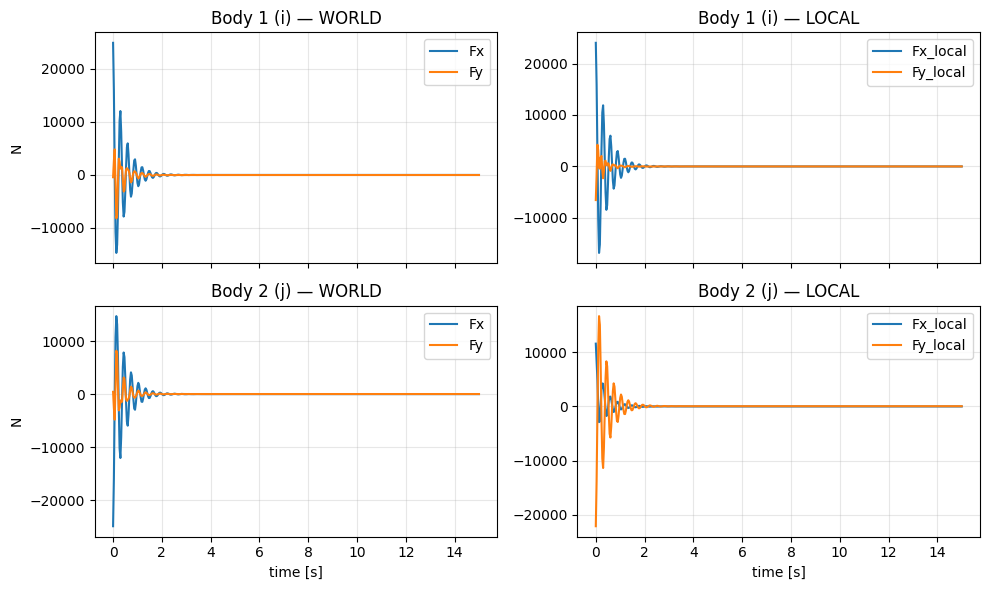

In [11]:
# ==== Joint 2 reaction: world vs local frames (body 1 and body 2) ====

# choose the revolute joint index
k = 2   # 0:(0-groundL), 1:(0-1), 2:(1-2), 3:(2-groundR)

# pull world-frame force from multipliers
F_world = lam[:, 2*k : 2*k+2]        # shape (K,2)

# bodies connected at joint k=2 are i=1, j=2 (0-based body IDs)
i_body, j_body = 1, 2

# force on each body in WORLD frame (equal/opposite)
F_on_i_world = -F_world               # on body i
F_on_j_world =  F_world               # on body j

# helper: rotation to body-local (A(φ)^T)
def to_local(Fw, phi):
    # Fw: (K,2), phi: (K,)
    Fl = np.empty_like(Fw)
    c, s = np.cos(phi), np.sin(phi)
    # A^T = [[c, s], [-s, c]]
    Fl[:,0] =  c*Fw[:,0] + s*Fw[:,1]
    Fl[:,1] = -s*Fw[:,0] + c*Fw[:,1]
    return Fl

# extract body angles over time
phi_i = q[:, 3*i_body + 2]
phi_j = q[:, 3*j_body + 2]

# transform to LOCAL frames
F_on_i_local = to_local(F_on_i_world, phi_i)
F_on_j_local = to_local(F_on_j_world, phi_j)

# --- plots ---
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10,6))

ax[0,0].plot(t, F_on_i_world[:,0], label="Fx")
ax[0,0].plot(t, F_on_i_world[:,1], label="Fy")
ax[0,0].set_ylabel("N"); ax[0,0].set_title("Body 1 (i) — WORLD"); ax[0,0].legend()
ax[0,0].grid(True, which="both", alpha=0.3)

ax[0,1].plot(t, F_on_i_local[:,0], label="Fx_local")
ax[0,1].plot(t, F_on_i_local[:,1], label="Fy_local")
ax[0,1].set_title("Body 1 (i) — LOCAL"); ax[0,1].legend()
ax[0,1].grid(True, which="both", alpha=0.3)

ax[1,0].plot(t, F_on_j_world[:,0], label="Fx")
ax[1,0].plot(t, F_on_j_world[:,1], label="Fy")
ax[1,0].set_ylabel("N"); ax[1,0].set_xlabel("time [s]")
ax[1,0].set_title("Body 2 (j) — WORLD"); ax[1,0].legend()
ax[1,0].grid(True, which="both", alpha=0.3)

ax[1,1].plot(t, F_on_j_local[:,0], label="Fx_local")
ax[1,1].plot(t, F_on_j_local[:,1], label="Fy_local")
ax[1,1].set_xlabel("time [s]")
ax[1,1].set_title("Body 2 (j) — LOCAL"); ax[1,1].legend()
ax[1,1].grid(True, which="both", alpha=0.3)
plt.savefig(f"reaction_forces_body_{b}.png", dpi=300, bbox_inches="tight")
plt.tight_layout(); plt.show()

